#Classificador de Espécies de Passáros

Esse notebook é inspirado na primeira aula do curso da fast.ai **Practical Deep
Learning for Coders**.

O objetivo deste projeto é constuir uma aplicação de machine learning que consiga classificar imagens de 9 diferentes espécies brasileiras. Para isso utilizei a biblioteca fast.ai e a técnica transfer-learning.

Para atingir os objetivos foram executados os seguintes passos:

- Configuração do Ambiente
- Scraping dos Dados
- Construção do Modelo
- Tunning do Modelo
- Prever a Classe de Imagens Novas


# Configurando o Google Colab

In [0]:
# First 3 lines only temporaly necessary, cause there is a bug on the actual version of FastAI/Pytorch
!curl -s https://course.fast.ai/setup/colab | bash
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0
#Needed for entire course
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#monting google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

### Instalando o gliser e imageMagick

Para realizar a coleta das imagens foi utilizado o script shell googliser, e o ImageMagick é um dos seus pré requisitos.

In [0]:
!apt install imagemagick

In [4]:
#getting the googliser script from GitHub
!bash <(wget -qO- git.io/get-googliser 1)

 Installing googliser ...
 Installation complete

 Type 'googliser -h' for help


# Scrap!

Eu escolhi 9 especies de aves encontradas no brasil para este estudo, algumas muito diferentes entre si como Tucanos e Beija-flores e outras bastante similares como Pombas e Rolinhas-roxas, para realmente testar o classificador.

Foram baixadas 300 imagens para cada classe.

In [0]:
for bird in ['beija-flor passaro','papagaio-verdadeiro passaro', 'bem-te-vi passaro',
             'joao-de-barro passaro', 'coleiro passaro', 'sabia-laranjeira passaro', 'rolinha-roxa passaro', 'tucano passaro', 'pomba passaro' ]:
             path = r'/content/gdrive/"My Drive"/"Colab Notebooks"/"Fast AI - Course"/data/'+bird.replace(' passaro', '')
             !googliser --phrase $bird --number 300 --upper-size 100000 -o $path 

# Importando a biblioteca fast.ai e apontando os dados.

O googliser foi um grande facilitador no momento de realizar o scrap em massa, porém nem todas as imagens baixadas eram realmente de passáros, então para esse projeto eu realizai uma limpeza manual nas pastas.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
bs = 64  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size
np.random.seed(2)
PATH = '/content/gdrive/My Drive/Colab Notebooks/Fast AI - Course/data'

O googliser baixou cada espécie em uma pasta separada, sendo o nome da pasta o da espécie. Então eu criei uma lista para armazena-las e chamei de classes.

In [6]:
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes)  

There are  9 classes:
 ['sabia-laranjeira', 'rolinha-roxa', 'tucano', 'joao-de-barro', 'coleiro', 'beija-flor', 'bem-te-vi', 'papagaio-verdadeiro', 'pomba']


Vamos verificar se não há nenhuma imagem corrompida nas pastas.

In [7]:
for c in classes:
    print ("Class:", c)
    verify_images(os.path.join(PATH, c), delete=True);

Class: sabia-laranjeira


Class: rolinha-roxa


Class: tucano


Class: joao-de-barro


Class: coleiro


Class: beija-flor


Class: bem-te-vi


Class: papagaio-verdadeiro


Class: pomba


# Criando e Treinando o Modelo

Primeiro passo para criar um modelo de classificação de imagens é criar um meio do modelo se conectar com as imagens. 

Assim como quando trabalhamos com tabelas utilizamos os Dataframes do Pandas, na biblioteca fast.ai quando trabalhamos com imagens temos a classe ImageDataBunch.

Essa classe é pensada para facilitar o trabalho do Cientista de Dados de diversas maneiras, uma delas é com uma função chamada **from_folder** que irá receber os dados de cada uma das pastas com nome das espécies, dividir as imagens em Treino/Validação na porcentagem especificada no parametro **valid_pct** e etiquetar nossas imagens com o nome de cada pasta.

Isso é incrivelmente útil para dados gerados de web scrap.

Vamos didivir os dados em 80% Treino e 20% validação.

In [0]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.2).normalize(imagenet_stats)

In [9]:
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 253 training images and 63 validation images.


Vamos visualizar exemplos de imagens das diferentes classes.

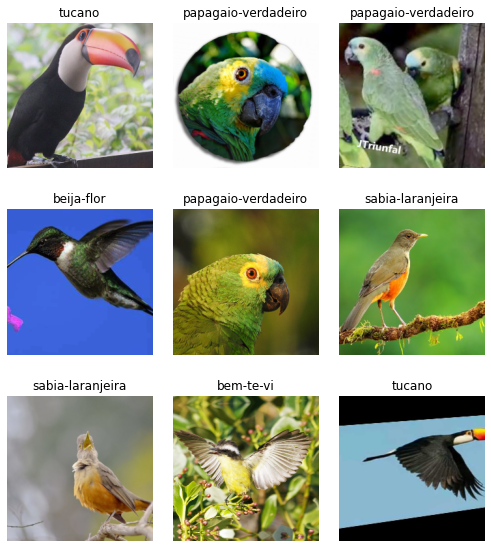

In [10]:
data.show_batch(rows=3, figsize=(7,8))

# Finalmente, vamos construir nosso modelo de Rede Neural Convolucional (CNN)

A arquitetura CNN ( Convolutional Neural Network) usada aqui será [ResNet34](https://arxiv.org/pdf/1512.03385.pdf). Esta arquitetura vem sendo usada nos últimos anos com muito sucesso em diversas aplicações e é considerada *Estado-da-Arte* 

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Simples assim, com uma linha escolhemos o modelo e a métrica, e com mais uma treinamos durante 5 ciclos.

Atingimos expressivos 92.06 % de acurácia, nada mal não é mesmo?

Esse resultado incrível só é possível pelo conceito de [*transfer learning*](https://en.wikipedia.org/wiki/Transfer_learning).

In [21]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.021611,2.327392,0.317460,00:05
1,2.137705,0.360800,0.920635,00:05
2,1.520009,0.258839,0.936508,00:05
3,1.133222,0.221218,0.936508,00:06
4,0.912391,0.211224,0.920635,00:06


# Vamos tentar interpretar um pouco esses 92% de acurácia

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

Estes são exemplos de erros na previsão, por exemplo a primeira imagem o modelo disse que era um Sabia-Laranjeira quando na verdade era um João de Barro.

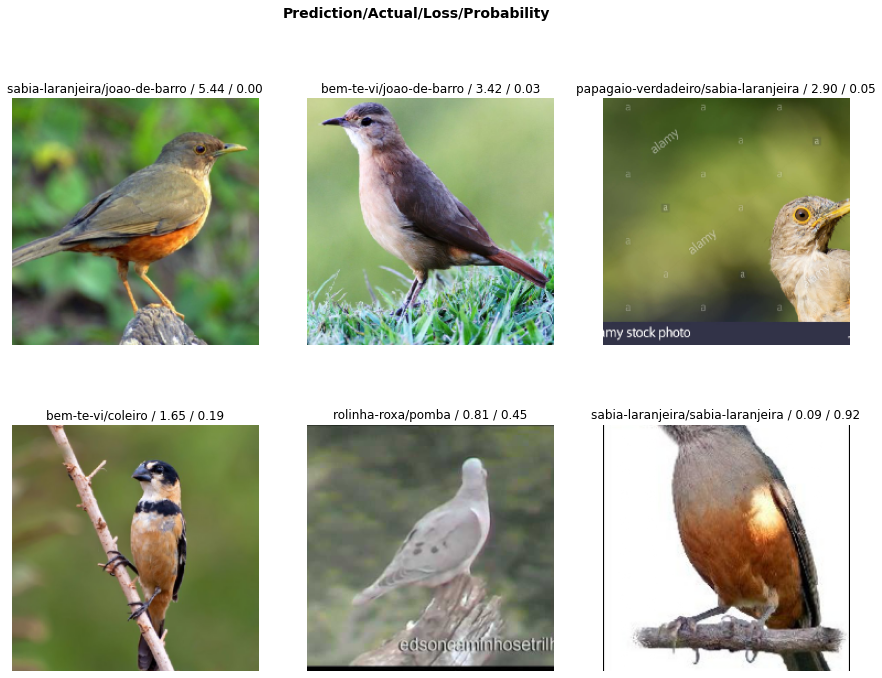

In [14]:
interp.plot_top_losses(6, figsize=(15,11))

In [15]:
interp.most_confused()

[('coleiro', 'bem-te-vi', 1),
 ('joao-de-barro', 'bem-te-vi', 1),
 ('joao-de-barro', 'sabia-laranjeira', 1),
 ('pomba', 'rolinha-roxa', 1),
 ('sabia-laranjeira', 'papagaio-verdadeiro', 1)]

In [0]:
learn.save('stage-1')

# Vamos tentar melhorar ainda mais nossas previsões

Para isso primeiro vou encontrar uma *learning rate* apropriada

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


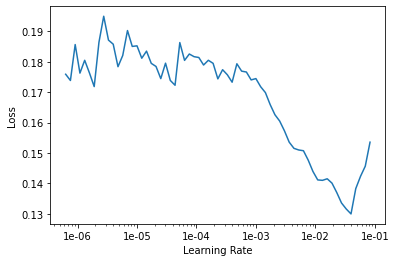

In [18]:
learn.recorder.plot()

A ideia aqui é criar um range de velocidade de aprendizado para cada um dos grupos de camadas (nossa tem 34 camadas) e fazer com que esse aprendizado mais customizado para nosso caso de aplicação melhore o acerto das previsões.

In [22]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.145399,0.206467,0.936508,00:06
1,0.126599,0.126203,0.968254,00:06
2,0.097412,0.137131,0.936508,00:06
3,0.080150,0.141187,0.936508,00:06
4,0.075363,0.136247,0.952381,00:06


Incrível! Atingimos 95.24 % de acurácia

#Prevendo a Classe de uma imagem completamente nova.

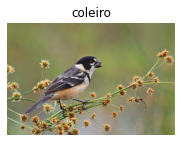

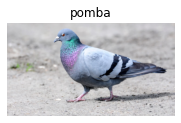

In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Fast AI - Course/Teste' #The path of your test image
for i in range(len(get_image_files(path))):
  img = open_image(get_image_files(path)[i])
  pred_class,pred_idx,outputs = learn.predict(img)
  img.show(title=str(pred_class))